# Logistic Regression with a Neural Network mindset

* Build the general architecture of a learning algorithm, including: 
    * Initializing parameters 
    * Calculating the cost function and its gradient 
    * Using an optimization algorithm (gradient descent)
* Gather all three functions above into a main model function, in the right order.


In [222]:
import numpy as np 
import matplotlib.pyplot as plt 
import h5py 
import scipy 
from PIL import Image 
from scipy import ndimage 
from lr_utils import load_dataset

%matplotlib inline

In [223]:
# Loading the data (cat/non-cat) 
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

y = [1], it's a 'cat' picture.


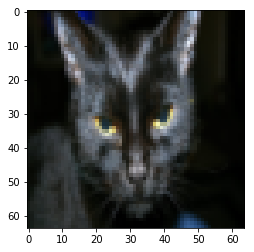

In [224]:
# Example of a picture 
index = 25
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + 
       classes[np.squeeze(train_set_y[:, index])].decode("utf-8") + 
       "' picture.") 

In [225]:
### START CODE HERE ### (3 lines of code)
# m_train (number of training examples) 
# m_test (number of test examples) 
# num_px (= height = width of a training image)
m_train = train_set_x_orig.shape[0] 
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]
### END CODE HERE ###

print ("Number of training examples: m_train = " + str(m_train)) 
print ("Number of testing examples: m_test = " + str(m_test)) 
print ("Height/Width of each image: num_px = " + str(num_px)) 
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape)) 
print ("train_set_y shape: " + str(train_set_y.shape)) 
print ("test_set_x shape: " + str(test_set_x_orig.shape)) 
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


### Reshape the training and test examples
* images of size (num_px, num_px, 3) are flattened into single vectors of shape (num_px·num_px·3, 1)
* A trick when you want to flatten a matrix X of shape (a,b,c,d) to a matrix X_flatten of shape (b·c·d, a) is to use:
    * X_flatten = X.reshape(-1,X.shape[0])

In [226]:
# Reshape the training and test examples 
#使维度满足：
    #X:(num_px * num_px * 3,number of examples)
    #Y:(1, number of examples)
    
#数组新的shape属性应该要与原来的配套，如果等于-1的话，那么Numpy会根据剩下的维度计算出数组的另外一个shape属性值。
#因为x_orig维度(m,px,px,3),所以要保留第一个m，使其每个m的剩下三维px,px,3组成一个列向量。
#然后再转置，是X符合(nx,m)规格。
#如果reshape(-1,test_set_x_orig.shape[0])，那么就会是m,px,px,3组成一个大list，再每m个分割为一个向量。
#这样样本之间就打乱了值。如果x_orig维度是(px,px,3，m)那么就应该用reshape(-1,test_set_x_orig.shape[0])，
#此时X已满足(nx,m)不需要转置。

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0],-1).T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape)) 
print ("train_set_y shape: " + str(train_set_y.shape)) 
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape)) 
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


In [227]:
#"Standardize" the data
#像素值分范围0-255，所以此处的“标准化”是都除以255
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

<font color='blue'>
**What you need to remember:**

Common steps for pre-processing a new dataset are:
- Figure out the dimensions and shapes of the problem (m_train, m_test, num_px, ...)
- Reshape the datasets such that each example is now a vector of size (num_px \* num_px \* 3, 1)
- "Standardize" the data

### General Architecture of the learning algorithm

**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

**Key steps**:
In this exercise, you will carry out the following steps: 
    - Initialize the parameters of the model
    - Learn the parameters for the model by minimizing the cost  
    - Use the learned parameters to make predictions (on the test set)
    - Analyse the results and conclude

In [228]:
def initialize_with_zeros(dim): 
    """ 
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    Argument: 
    dim -- size of the w vector we want (or number of parameters in this case).
    Returns: 
    w -- initialized vector of shape (dim, 1) 
    b -- initialized scalar (corresponds to the bias) 
    解释W(dim,1)的原因:
    z=w1*x1+w2*x2+w3*x3+......wm*xm+b
    yhat=sigmod(z)
    b是标量，一个数值。
    """
    w = np.zeros((dim,1)) 
    b = 0
    assert(w.shape == (dim, 1)) 
    assert(isinstance(b, float) or isinstance(b, int))
    return w, b

In [229]:
# GRADED FUNCTION: sigmoid 
def sigmoid(z): 
    """ 
    Compute the sigmoid of z
    Arguments: 
    z -- A scalar or numpy array of any size
    Return
    s -- sigmoid(z) 
    """
    s = 1/(1+np.exp(-z))
    return s

### Forward and Backward propagation 

Forward Propagation:
- You get X
- You compute $A = \sigma(w^T X + b) = (a^{(0)}, a^{(1)}, ..., a^{(m-1)}, a^{(m)})$
- You calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Here are the two formulas you will be using: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [230]:
# GRADED FUNCTION: propagate 
def propagate(w, b, X, Y): 
    """ 
    Implement the cost function and its gradient for the propagation explained above.
    Arguments: 
    w -- weights, a numpy array of size (num_px * num_px * 3, 1) 
    b -- bias, a scalar X -- data of size (num_px * num_px * 3, number of examples) 
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples).
    Return: 
    cost -- negative log-likelihood cost for logistic regression 
    dw -- gradient of the loss with respect to w, thus same shape as w 
    db -- gradient of the loss with respect to b, thus same shape as b
    Tips: - Write your code step by step for the propagation. np.log(), np.dot().
    """
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST) 
    A = sigmoid(np.dot(w.T,X)+b)
    #A的维度:(1,m)=Y的维度,w:(nx,1),X:(nx,m)
    # compute activation 
    
    #确保np.dot的第一个矩阵是(1,m),第二个是(m,1)
    cost = -(np.dot(Y,np.log(A.T))+np.dot(np.log(1-A),(1-Y).T))/m
    # compute cost, 
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    #单个样本：
    #da=-y/a+(1-y)/(1-a)
    #dz=a-y
    #dw=dz*x
    #db=dz
    #m个样本：
    #dZ=A-Y
    #dW=(1/m)(X*dZ.T)
    #db=(1/m)*(np.sum(dZ,axis=1,keepdims=True))
    dw = np.dot(X,(A-Y).T)/m 
    db = np.sum(A-Y)/m
    assert(dw.shape == w.shape) 
    assert(db.dtype == float) 
    cost = np.squeeze(cost) 
    assert(cost.shape == ())
    grads = {"dw": dw, "db": db}
    return grads, cost

In [231]:
# GRADED FUNCTION: optimize
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False): 
    """ 
    This function optimizes w and b by running a gradient descent algorithm, 
    Arguments: 
    w -- weights, a numpy array of size (num_px * num_px * 3, 1) 
    b -- bias, a scalar 
    X -- data of shape (num_px * num_px * 3, number of examples) 
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples).
    num_iterations -- number of iterations of the optimization loop 
    learning_rate -- learning rate of the gradient descent update rule 
    print_cost -- True to print the loss every 100 steps
    Returns: 
    params -- dictionary containing the weights w and bias b 
    grads -- dictionary containing the gradients of the weights and bias
             with respect to the cost function
    costs -- list of all the costs computed during the optimization, 
             this will be used to plot the learning curve.
    Tips: You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    costs = []
    #迭代num_iterations次，w=w-a*dw，b=b-a*db，cost = -(np.dot(Y,np.log(A.T))+np.dot(np.log(1-A),(1-Y).T))/m，与Y和A有关，
    #Y是固定量，但是每次迭代都改变A，即，A是学习变量。A = sigmoid(np.dot(w.T,X)+b)，每次迭代，都会改变w和b。
    for i in range(num_iterations):
        # Cost and gradient calculation (1-4 lines of code) 
        ### START CODE HERE ### 
        grads, cost = propagate(w, b, X, Y)
        ### END CODE HERE ###
        # Retrieve derivatives from grads 
        dw = grads["dw"] 
        db = grads["db"]
        # update rule (2 lines of code) 
        ### START CODE HERE ###
        #w=w-a*dw
        #b=b-a*db
        w = w-learning_rate*dw 
        b = b-learning_rate*db 
        ### END CODE HERE ###
        # Record the costs 
        if i % 100 == 0: 
            costs.append(cost)
        # Print the cost every 100 training examples 
        if print_cost and i % 100 == 0: 
            print ("Cost after iteration %i: %f" %(i, cost))
    params = {"w": w, 
              "b": b}
    grads = {"dw": dw, 
             "db": db}
    return params, grads, costs


In [232]:
#w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])
w=np.array([[1.],[2.]])
b=2.
X=np.array([[1.,2.,-1.],[3.,4.,-3.2]])
Y=np.array([[1,0,1]])
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, 
                                learning_rate = 0.009, print_cost = False)
print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print("costs = "+str(costs))

w = [[ 0.19033591]
 [ 0.12259159]]
b = 1.92535983008
dw = [[ 0.67752042]
 [ 1.41625495]]
db = 0.219194504541
costs = [array(5.801545319394553)]


In [237]:
#propagate没有返回A，如果返回A，那么最后一个A就是预测的yhat，并非(0，1)形式，而是介于0-1之间。
# GRADED FUNCTION: predict
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b) 
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    ''' 
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    #w的行数和X的函数相同，列数为1，如果W已经符合了，则不会有任何转变。
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    ### START CODE HERE ### (≈ 1 line of code)
    A = sigmoid(np.dot(w.T, X) + b)
    ### END CODE HERE ###
    """
    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        ### START CODE HERE ### (≈ 4 lines of code)
        if A[0, i] <= 0.5:
            Y_prediction[0, i] = 0
        else:
            Y_prediction[0, i] = 1
        ### END CODE HERE ###
    """
    Y_prediction[0]=np.round(A[0])
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

### Merge all functions into a model 

In [238]:
# GRADED FUNCTION: model
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """ 
    Builds the logistic regression model by calling the function you've implemented previously
    Arguments: 
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate 
                     used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    Returns: 
    d -- dictionary containing information about the model. 
    """
    ### START CODE HERE ###
    # initialize parameters with zeros (1 line of code) 
    w, b = initialize_with_zeros(X_train.shape[0])
    # Gradient descent (1 line of code) 
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"] 
    b = parameters["b"]
    # Predict test/train set examples (2 lines of code) 
    Y_prediction_test = predict(w, b, X_test) 
    Y_prediction_train = predict(w, b, X_train)
    ### END CODE HERE ###
    # Print train/test Errors 
    print("train accuracy: {} %".format(100-np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100-np.mean(np.abs(Y_prediction_test - Y_test)) * 100))
    #等效于：
    #print("test accuracy:{}%".format((1-np.mean(np.abs(Y_prediction_test-Y_test)))*100))
    d = {"costs": costs, 
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, "b" : b, 
         "learning_rate" : learning_rate, 
         "num_iterations": num_iterations}
    return d 

In [239]:
print(train_set_y.shape)
print(train_set_x.shape)
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

(1, 209)
(12288, 209)
Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


* np.squeeze用法：
* 从数组的形状中删除单维条目，即把shape中为1的维度去掉

[array(0.6931471805599453), array(0.5845083636993086), array(0.4669490409465547), array(0.37600686694802077), array(0.3314632893282513), array(0.30327306747438293), array(0.27987958658260487), array(0.2600421369258757), array(0.2429406846779662), array(0.22800422256726066), array(0.2148195137844964), array(0.20307819060644988), array(0.19254427716706857), array(0.18303333796883509), array(0.17439859438448874), array(0.16652139705400335), array(0.15930451829756614), array(0.152667324712965), array(0.14654223503982342), array(0.1408720757031016)]


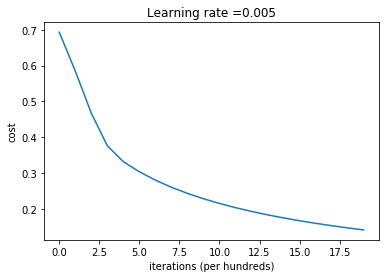

In [236]:
# Plot learning curve (with costs) 
#这个costs是个list，其实可以不用np.squeeze
print(d['costs'])
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost') 
plt.xlabel('iterations (per hundreds)') 
plt.title("Learning rate =" + str(d["learning_rate"])) 
plt.show()
#y轴是以迭代100次为单位

<font color='blue'>
**What to remember:**
You've implemented several functions that:
- Initialize (w,b)
- Optimize the loss iteratively to learn parameters (w,b):
    - computing the cost and its gradient 
    - updating the parameters using gradient descent
- Use the learned (w,b) to predict the labels for a given set of examples

### Choice of learning rate 

In [213]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

learning rate is: 0.01
train accuracy: 99.52153110047847 %
test accuracy: 68.0 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 88.99521531100478 %
test accuracy: 64.0 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 68.42105263157895 %
test accuracy: 36.0 %

-------------------------------------------------------



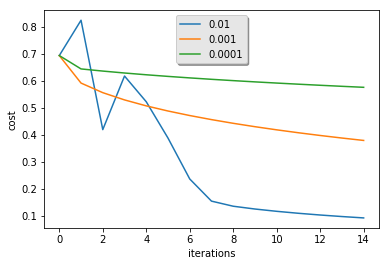

In [221]:
for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()